# SOC LEAF Example
In this example, SOC LEAF for Maize, rainfed, plant residues removed, traditional tillage production will be developed for a 2030 and 2050 scenario. The process assumes that the land use is kept the same, and that weather and crop data do not change over time, generating LEAF for the input land use map using the default values previously mentioned on [SOC Documentation](../documentation/SOC_Documentation.md). 

A similar approach can be implemented with a different land use map and/or using primary data regarding yields, plant cover, plant residues, soil and weather data. The methods can be changed to simulate crop rotations, organic ammendments, multi-crop systems, among others.

## Data Download and Processing
As explained in SOC Documentation, several data layers need to be downloaded first. This examples uses all potential locations where maize could be grown under rainfed conditions, according to [FAO GAEZ](https://www.fao.org/gaez/en/) v2. A newer version (v5 on the moment of publishing) has been released but to keep consistency with original SOC method framework it has not been updated.

### Soil & Weather
Precipitation and air temperature data have been downloaded and processed. It be found under [data/](../data/). SoilGrids data have been downloaded and processed into UHTH zones in the needed format and is also available in the same folder. 

**🚧 TODO: Update reference 🚧**
This data is too large to be be hosted in a github repository. Instructions into how to download it can be found on XXX

### Crop Data
Land use layer has been adapted from Morais, Teixeria & Domingos (2019) and can be found under [examples/soc_ex_data](../examples/soc_ex_data/).

Commodity yield input data from FAO has already been summarized and can be found at [data/crops/fao_crop_yields_1423.csv](data/crops/fao_crop_yields_1423.csv) file. The needed SPAM data has been downloaded into [data/crops/spam2020V2r0_global_yield](data/crops/spam2020V2r0_global_yield) folder - only Maize data is uploaded, but other crops data layers are recommended to be placed under the same folder.

All other needed data to calculate potential crop evapotranspiration, including pre-calculated PET-location based layer, $K_c$ values, stage durations, as well as other supporting data has been uploaded into [data/crops](../data/crops/) folder.

## Data Processing
Now that all data has been downloaded and prepared, the following modules are needed

In [9]:
# Modules importing
import polars as pl
import matplotlib.pyplot as plt
import importlib
import os
import pandas as pd

import sbtn_leaf.RothC_Raster as rothC
import sbtn_leaf.cropcalcs as cropcalcs
import sbtn_leaf.map_plotting as mplot

def reload_cropcalcs():
    importlib.reload(cropcalcs)

def reload_rothC():
    importlib.reload(rothC)

def reload_mplot():
    importlib.reload(mplot)

Now the rest of the data can be prepared to calculate new LEAFs. The `cropcals.prepare_crop_data()` function automatizes the creation of yields maps, monthly plant cover, monthly PET, monthly irrigation, and monthly plant residue for a given land use commodity raster. All these inputs have their own function that can be directly run instead to reflect different primary data.

Before running the function, the following fields should be defined:

In [12]:
lu_filepath = "../examples/soc_ex_data/Maize_irr_lu.tif"
spam_maize_all = "../data/crops/spam2020V2r0_global_yield/spam2020_V2r0_global_Y_MAIZ_A.tif"
spam_maize_irr = "../data/crops/spam2020V2r0_global_yield/spam2020_V2r0_global_Y_MAIZ_I.tif"
spam_maize_rain = "../data/crops/spam2020V2r0_global_yield/spam2020_V2r0_global_Y_MAIZ_R.tif"
input_data_output_folder = "../examples/soc_ex_data"

Now running `cropcals.prepare_crop_data()` to ready all RothC inputs for Maize, rainfed. If this example has already been run, the function will skip generating already generated files. This should take a couple of minutes.

In [13]:
cropcalcs.prepare_crop_data(
    crop_name = "Maize",
    crop_practice_string = "rf",
    lu_data_path = lu_filepath,
    spam_crop_raster = spam_maize_rain,
    output_data_folder = input_data_output_folder,
    irr_yield_scaling = "rf",
    spam_all_fp = spam_maize_all,
    spam_irr_fp = spam_maize_irr,
    spam_rf_fp = spam_maize_rain
)

Land use binary raster already exist. Skipping...
PET raster already exists — skipping computation.
Irrigation raster already exists — skipping computation.
Creating Maize (corn) shapefile...
Yields raster already exists — skipping computation.
Plant Cover raster already exists — skipping computation.
Plant Residues raster already exists — skipping computation.
All data created for Maize, rf!!!


### Inspecting outputs
Inspecting the yield data results.

In [14]:
maize_rf_yields = "../examples/soc_ex_data/Maize_rf_yield.tif"

Raster has 82,695 different values. Min: 0.20. Max: 13.65
Using quantiles
All positives route


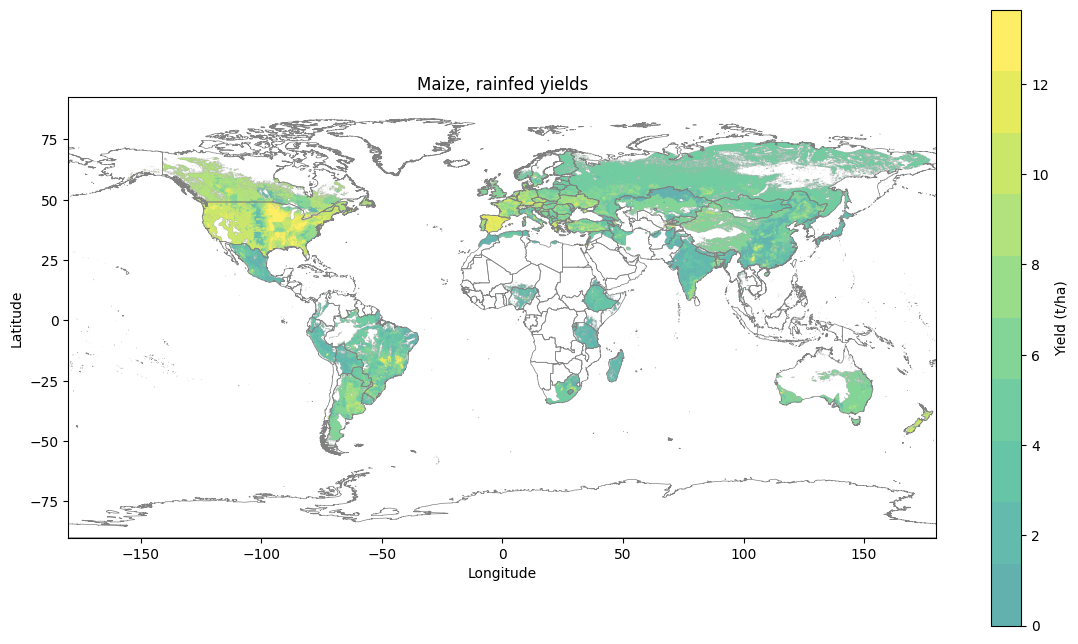

In [15]:
mplot.plot_raster_on_world_extremes_cutoff(
    tif_path=maize_rf_yields,
    title="Maize, rainfed yields",
    label_title="Yield (t/ha)",
    quantiles=10
)

Maize PET - Monthly

In [16]:
maize_pet_monthly = "../examples/soc_ex_data/Maize_pet_monthly.tif"

Raster has 993,711 different values. Min: 0.00. Max: 256.88
Using quantiles
All positives route


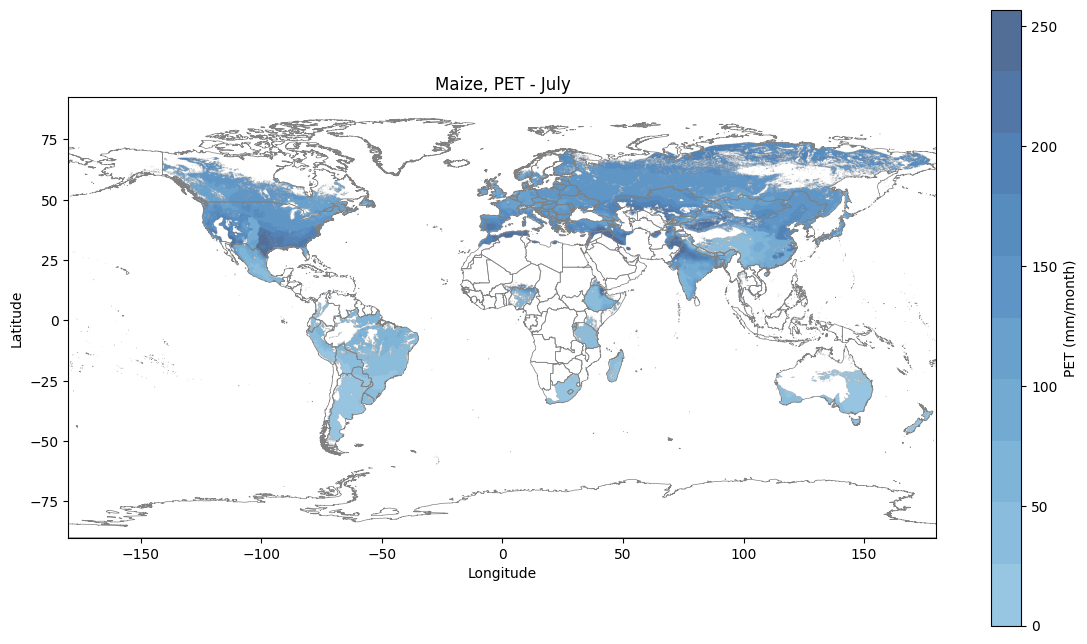

In [17]:
mplot.plot_raster_on_world_extremes_cutoff(
    tif_path=maize_pet_monthly,
    title="Maize, PET - July",
    raster_band=7,
    label_title="PET (mm/month)",
    quantiles=10,
    cmap="Blues"
)

## RothC Modelling
With all data generated, the RothC model can be run. SoilGrids SOC data is from 2016, so in order to generate 2030 and 2050 maps aligned with SBTi's short and long-term targets, two LEAFs set will be generated: 34 and 54 years. Further, in this case, plant residues will be removed from the field, and traditional tillage applied.

Defining the needed additional inputs:

In [18]:
evap = "../examples/soc_ex_data/Maize_pet_monthly.tif"
pc = "../examples/soc_ex_data/Maize_pc_monthly.tif"
leaf_output_folder = "../examples/soc_ex_output"

Now running the RothC model. Depending on the amount of years and land modelled, this could take from a few minutes to 1+ hours.

Running for 2030 scenario 

In [23]:
reload_rothC()

In [ ]:
leaf_maize_rf_resoff_ct_2030 = rothC.run_RothC(
    crop_name = "Maize",
    practices_string_id= "rf_resoff_ct",
    n_years = 34,
    save_folder = leaf_output_folder,
    data_description = "RothC model results after 34 years for Maize, rainfed, residues removed from field, conventional tillage",
    lu_fp = lu_filepath,
    evap_fp = evap,
    pc_fp = pc
)

Loading environmental data...
Loading crop data...
Running RothC...


C:\Users\loyola\OneDrive - World Wildlife Fund, Inc\Documents\203. Python projects\SBTN_Test\src\sbtn_leaf\RothC_Core.py:56: RuntimeWarning: overflow encountered in exp
  rmf = 47.91 / (np.exp(106.06 / (tmp + 18.27)) + 1.0)
RothC months: 100%|██████████| 408/408 [17:25<00:00,  2.56s/it]


#### Checking results
Now that results have been generated, they can be inspected.

In [25]:
leaf_maize_rf_resoff_ct_2030_tif = "../examples/soc_ex_output/Maize_rf_resoff_ct_34y_SOC.tif"

Checking the properties of the raster...

In [26]:
mplot.inspect_raster(leaf_maize_rf_resoff_ct_2030_tif)

File: ../examples/soc_ex_output/Maize_rf_resoff_ct_34y_SOC.tif
Driver: GTiff
Width, Height: 4320, 2083
Number of Bands: 35
CRS: EPSG:4326
Bounds: BoundingBox(left=-179.99999999999997, bottom=-89.99999999999994, right=179.99999999999991, top=83.58333333333331)
Pixel Size: (0.0833333333333333, 0.0833333333333333)
No-data Value: nan

--- Raster Metadata ---
description: RothC model results after 34 years for Maize, rainfed, residues removed from field, conventional tillage
long_name: Soil Organic Carbon
model: RothC rasterized vectorized
units: t C/ha
AREA_OR_POINT: Area

--- Band Information ---

Band 1:
  Data Type: float32
  Min Value: 6.81576681137085
  Max Value: 166.87579345703125
  Mean Value: 55.2380485534668
  Standard Deviation: 20.117786407470703

Band 2:
  Data Type: float32
  Min Value: 6.573349475860596
  Max Value: 154.8661346435547
  Mean Value: 52.665000915527344
  Standard Deviation: 20.185115814208984

Band 3:
  Data Type: float32
  Min Value: 6.4735636711120605
  Max V

Checking Global SOC evolution. This can be replicated or zoomed into a particular region or production unit.

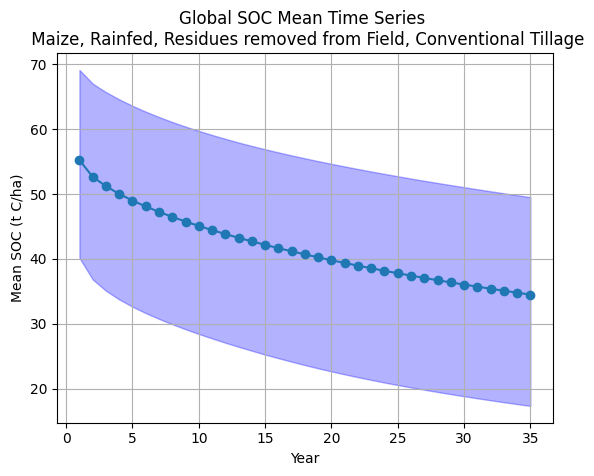

In [27]:
mplot.plot_multiband_raster_timesires(leaf_maize_rf_resoff_ct_2030_tif, "Global SOC Mean Time Series \n Maize, Rainfed, Residues removed from Field, Conventional Tillage", show_iq=True)

It can be seen that, on average, SOC would be depleted under this operating conditions if kept over time.

Checking LEAF map for 2030

Raster has 1,023,086 different values. Min: 5.74. Max: 82.79
Using quantiles
All positives route


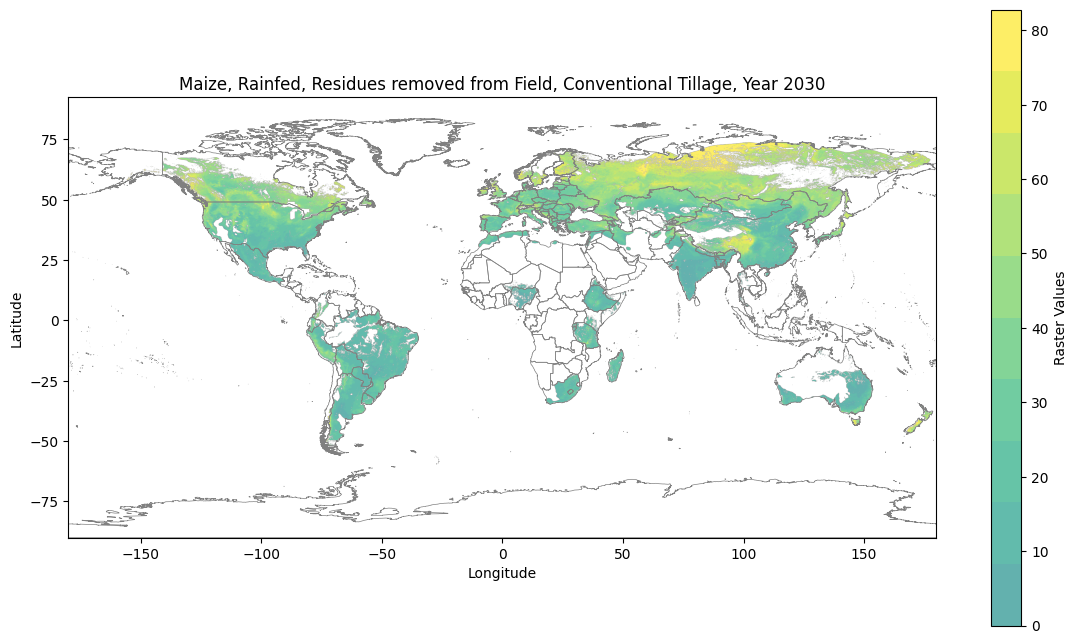

In [29]:
mplot.plot_raster_on_world_extremes_cutoff(leaf_maize_rf_resoff_ct_2030_tif, "Maize, Rainfed, Residues removed from Field, Conventional Tillage, Year 2030", raster_band=34, alpha=1, quantiles=10)

Now checking how it changed between the baseline and 2030. This can be done with the function`rothC.calcuate_annual_perc_changes()`.

In [30]:
pct_change_2030 = rothC.calcuate_annual_perc_changes(leaf_maize_rf_resoff_ct_2030_tif)

Raster has 983,610 different values. Min: -81.31. Max: -9.85
Using quantiles
All negatives route


(<Figure size 1400x800 with 2 Axes>,
 <Axes: title={'center': 'SOC Percentage change by year 2030 for \nMaize, Rainfed, Residues removed from Field, Conventional Tillage'}, xlabel='Longitude', ylabel='Latitude'>)

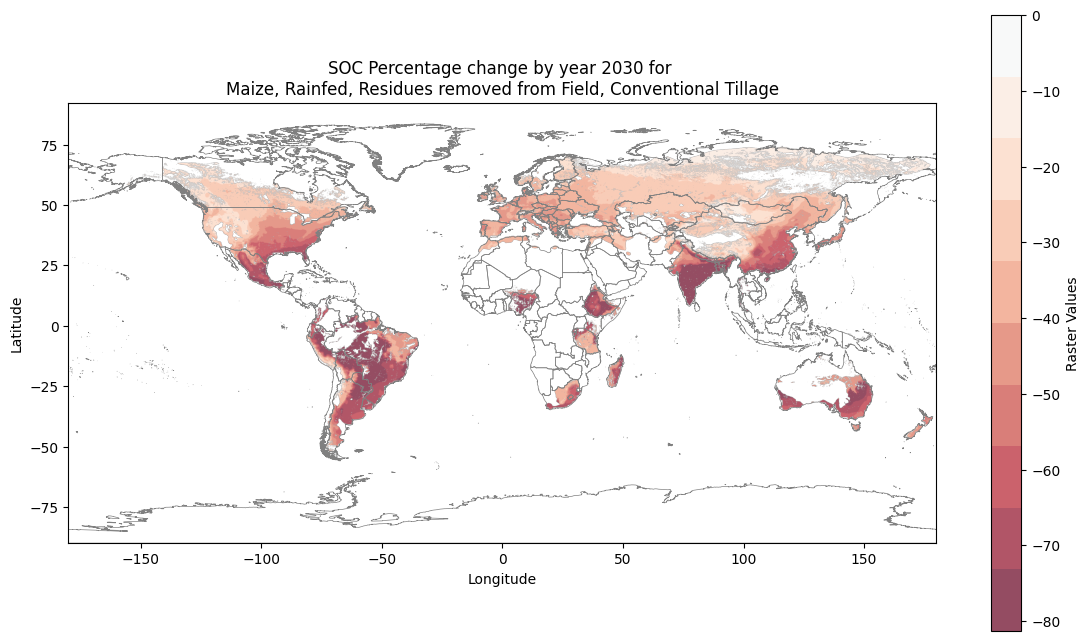

In [ ]:
mplot.plot_da_on_world_extremes_cutoff(pct_change_2030, "SOC Percentage change by year 2030 for \nMaize, Rainfed, Residues removed from Field, Conventional Tillage", band=34, cmap="RdBu", quantiles=10) # type: ignore

Where it can be noted that there is no place where this operating conditions would increase SOC. Rather, SOC would decrease between 10% and 80% throughout the globe.

### Batch scenario assessment
Users might want to run several different scenarios, either for a different set of crops, land management options or years in assessment. In order to simplify the process, batch scenario functions have been created. The function `cropcalcs.prepare_crop_scenarios()` creates the input data for different crops and irrigation practices using the function `cropcalcs.prapare_crop_data()`, while the function `rothC.run_rothC_sceneraios_from_csv()` can generate several rothC outputs for a different number of years, crops, and land management practices  currently available.

#### Scenario data preparation
A csv listing crop names, irrigation scenarios, as well as input SPAM data layers needs to be prepared. For this example, [`maize_scenarios_data.csv`](../examples/soc_ex_data/maize_scenarios_data.csv) is used.

The csv has the following format:

In [37]:
# Loading csv
maize_scenarios_fp = '../examples/soc_ex_data/maize_scenarios_data.csv'
maize_scenario_list = pl.read_csv(maize_scenarios_fp)

In [38]:
# Printing csv example
maize_scenario_list

crop_name,crop_practice_string,lu_data_path,spam_crop_raster,output_data_folder,irr_yield_scaling,spam_all_fp,spam_irr_fp,spam_rf_fp,all_new_files
str,str,str,str,str,str,str,str,str,bool
"""Maize""","""irr""","""../examples/soc_ex_data/Maize_…","""../data/crops/spam2020V2r0_glo…","""../examples/soc_ex_data""","""irr""","""../data/crops/spam2020V2r0_glo…","""../data/crops/spam2020V2r0_glo…","""../data/crops/spam2020V2r0_glo…",true
"""Maize""","""rf""","""../examples/soc_ex_data/Maize_…","""../data/crops/spam2020V2r0_glo…","""../examples/soc_ex_data""","""rf""","""../data/crops/spam2020V2r0_glo…","""../data/crops/spam2020V2r0_glo…","""../data/crops/spam2020V2r0_glo…",true


Note that users can override the skip creating already existing files and create a whole new set of files using *all_new_files = True*.

Once the csv has been created then the cropcalcs function, which can take several minutes to run, is simply:

In [41]:
cropcalcs.prepare_crop_scenarios(maize_scenarios_fp)

Preparing data for Maize, irr
Land use binary raster already exist. Skipping...
PET raster already exists — skipping computation.
Irrigation raster already exists — skipping computation.
Creating Maize (corn) shapefile...
Creating yield raster...
Average irrigated ratio: 1.7520839058709115
Average rainfed ratio: 0.9714865494249993
  → Applying irrigation scaling to all‐SPAM yields…
Yield raster written to ../examples/soc_ex_data/Maize_irr_yield.tif
Plant Cover raster already exists — skipping computation.
Creating plant residue raster...
All data created for Maize, irr!!!
Next!


Preparing data for Maize, rf
Land use binary raster already exist. Skipping...
PET raster already exists — skipping computation.
Irrigation raster already exists — skipping computation.
Creating Maize (corn) shapefile...
Yields raster already exists — skipping computation.
Plant Cover raster already exists — skipping computation.
Plant Residues raster already exists — skipping computation.
All data created for

And all done.

#### Running RothC for several scenarios
Once data has been prepared, a similar process is repeated to run different RothC scenarios. In this case, a different csv file listing the different inputs is needed. [`maize_rothc_scenarios.csv`](../examples/soc_ex_data/maize_rothc_scenarios.csv) contains the scenarios used for this example, which in this case is the missing 2050 sceanrio for the same land management options, as well 2030 scenerios for irrigated production and another one with conservative tillage.

The csv file has the following format:

In [42]:
maize_rothc_scenarios_fp ='../examples/soc_ex_data/maize_rothc_scenarios.csv'
maize_rothc_scenarios_csv = pl.read_csv(maize_rothc_scenarios_fp)
maize_rothc_scenarios_csv

crop_name,practices_string_id,n_years,save_folder,data_description,lu_fp,evap_fp,pc_fp,irr_fp,pr_fp,fym_fp,red_till,save_CO2
str,str,i64,str,str,str,str,str,str,str,str,bool,bool
"""Maize""","""irr_resoff_convt""",34,"""../examples/soc_ex_output""","""RothC model results after 34 y…","""../examples/soc_ex_data/Maize_…","""../examples/soc_ex_data/Maize_…","""../examples/soc_ex_data/Maize_…","""../examples/soc_ex_data/Maize_…",null,null,false,false
"""Maize""","""rf_resoff_convt""",54,"""../examples/soc_ex_output""","""RothC model results after 54 y…","""../examples/soc_ex_data/Maize_…","""../examples/soc_ex_data/Maize_…","""../examples/soc_ex_data/Maize_…",null,null,null,false,false
"""Maize""","""rf_resoff_redt""",34,"""../examples/soc_ex_output""","""RothC model results after 34 y…","""../examples/soc_ex_data/Maize_…","""../examples/soc_ex_data/Maize_…","""../examples/soc_ex_data/Maize_…",null,null,null,true,false


As it can be seen, by simply omitting some filepaths the function assumes that said land management practice is not implemented. To actually run **reduced tillage**, the input red_till needs to be assigned as *TRUE*.

Now, running all the scenarios. This will take around 1 hour considering the amount of scenarios and years modelled.

In [44]:
rothC.run_rothC_sceneraios_from_csv(maize_rothc_scenarios_fp)

Running Maize - irr_resoff_convt
Loading environmental data...
Loading crop data...
Running RothC...


C:\Users\loyola\OneDrive - World Wildlife Fund, Inc\Documents\203. Python projects\SBTN_Test\src\sbtn_leaf\RothC_Core.py:56: RuntimeWarning: overflow encountered in exp
  rmf = 47.91 / (np.exp(106.06 / (tmp + 18.27)) + 1.0)
RothC months: 100%|██████████| 408/408 [17:29<00:00,  2.57s/it]





Running Maize - rf_resoff_convt
Loading environmental data...
Loading crop data...
Running RothC...


C:\Users\loyola\OneDrive - World Wildlife Fund, Inc\Documents\203. Python projects\SBTN_Test\src\sbtn_leaf\RothC_Core.py:56: RuntimeWarning: overflow encountered in exp
  rmf = 47.91 / (np.exp(106.06 / (tmp + 18.27)) + 1.0)
RothC months: 100%|██████████| 648/648 [30:00<00:00,  2.78s/it]





Running Maize - rf_resoff_redt
Loading environmental data...
Loading crop data...
Running RothC...


C:\Users\loyola\OneDrive - World Wildlife Fund, Inc\Documents\203. Python projects\SBTN_Test\src\sbtn_leaf\RothC_Core.py:56: RuntimeWarning: overflow encountered in exp
  rmf = 47.91 / (np.exp(106.06 / (tmp + 18.27)) + 1.0)
RothC months: 100%|██████████| 408/408 [17:24<00:00,  2.56s/it]


Notice that the 2050 results include 2030 onces, as the resulting rasters include 1 year snapshots for every year modelled.

##### Inspecting Results
Now that the scenarios have been run, we can see how the changed compared to the previous baseline.

Resulting maps have been stored under:

In [47]:
leaf_maize_rf_resoff_ct_2050_tif = "../examples/soc_ex_output/Maize_rf_resoff_convt_54y_SOC.tif"
leaf_maize_irr_resoff_ct_2030_tif = "../examples/soc_ex_output/Maize_irr_resoff_convt_34y_SOC.tif"
leaf_maize_rf_resoff_rt_2030_tif = "../examples/soc_ex_output/Maize_rf_resoff_redt_34y_SOC.tif"

Checking maps...

Raster has 1,025,908 different values. Min: 3.41. Max: 77.95
Using quantiles
All positives route


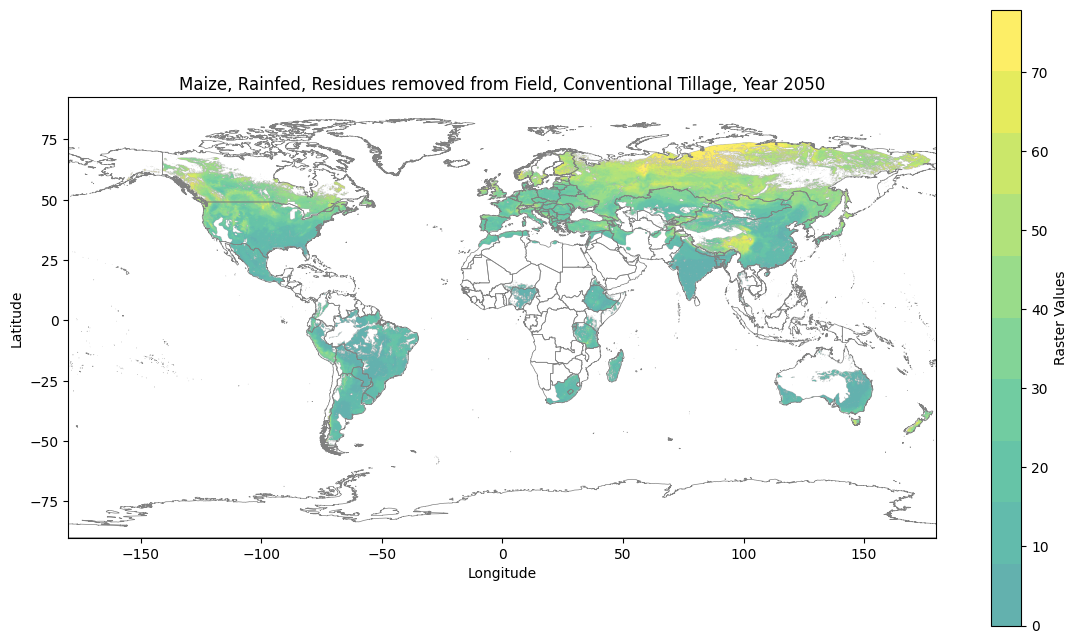

In [48]:
mplot.plot_raster_on_world_extremes_cutoff(leaf_maize_rf_resoff_ct_2050_tif, "Maize, Rainfed, Residues removed from Field, Conventional Tillage, Year 2050", raster_band=54, alpha=1, quantiles=10)

Where it can be seen that although the distribution stays the same, the last quantile modeled has reduced to 70 t C/ha after 20 extra years.

Raster has 1,025,206 different values. Min: 3.83. Max: 75.69
Using quantiles
All positives route


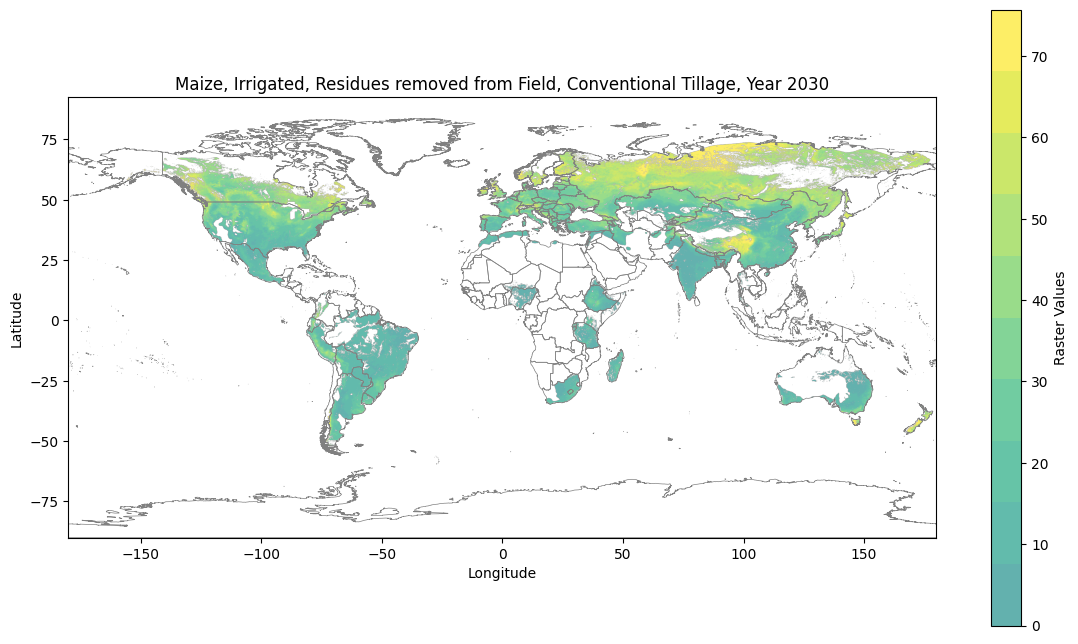

In [49]:
mplot.plot_raster_on_world_extremes_cutoff(leaf_maize_irr_resoff_ct_2030_tif, "Maize, Irrigated, Residues removed from Field, Conventional Tillage, Year 2030", raster_band=34, alpha=1, quantiles=10)

Irrigation practices would accelerate SOC loss, as a similar range of values is plotted for 2030 than compared to 2050 with baseline land management conditions.

Raster has 1,022,830 different values. Min: 6.14. Max: 83.25
Using quantiles
All positives route


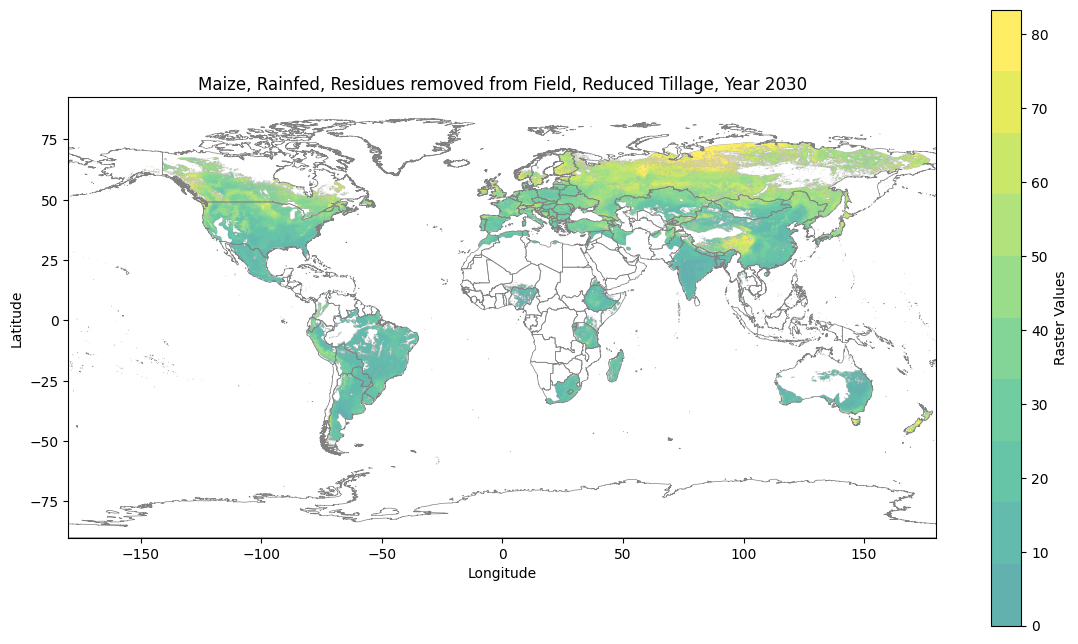

In [50]:
mplot.plot_raster_on_world_extremes_cutoff(leaf_maize_rf_resoff_rt_2030_tif, "Maize, Rainfed, Residues removed from Field, Reduced Tillage, Year 2030", raster_band=34, alpha=1, quantiles=10)

Using reduced tillage instead of conventional tillage will lead to slightly higher SOC stocks than using conventional tillage.

Plotting the average global SOC values as a time series allows an easier comparison. 

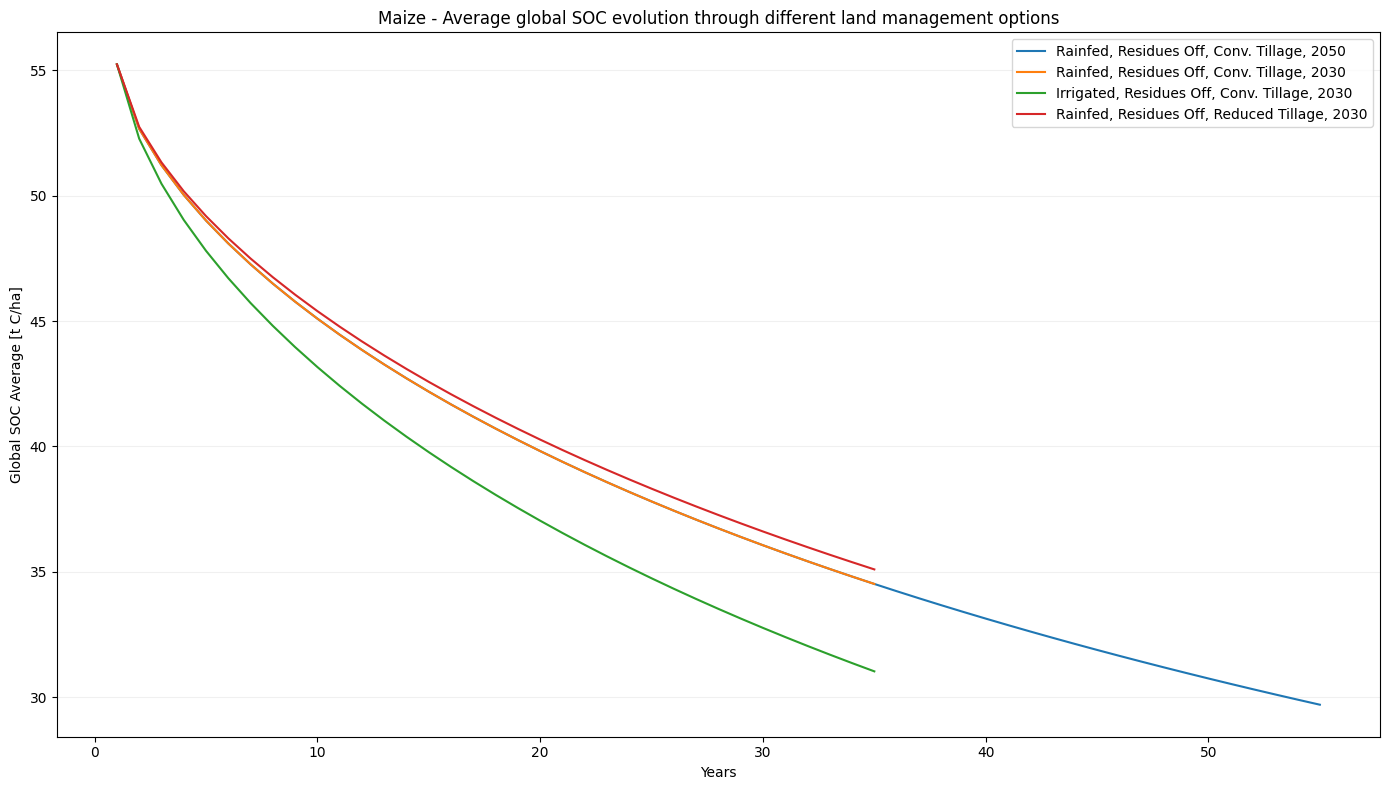

In [61]:
maize_scenarios_tif = [
    leaf_maize_rf_resoff_ct_2050_tif,
    leaf_maize_rf_resoff_ct_2030_tif,
    leaf_maize_irr_resoff_ct_2030_tif,
    leaf_maize_rf_resoff_rt_2030_tif
]
maize_labels = [
    "Rainfed, Residues Off, Conv. Tillage, 2050",
    "Rainfed, Residues Off, Conv. Tillage, 2030",
    "Irrigated, Residues Off, Conv. Tillage, 2030",
    "Rainfed, Residues Off, Reduced Tillage, 2030"
]

reload_mplot()
mplot.plot_average_band_values(maize_scenarios_tif, maize_labels, "Maize - Average global SOC evolution through different land management options", ylabel="Global SOC Average [t C/ha]",xlabel="Years", show_iq=False)

The plot visualizes the tendencies previously described globally, with conservation tillage slightly increasing the global SOC average in 2030 when compared to the baseline.

 As the model runs for each pixel independently, it can also identify which areas have improving or worsening conditions.

In [63]:
pct_change_redtill = rothC.calcuate_annual_perc_changes(leaf_maize_rf_resoff_rt_2030_tif)

Raster has 982,095 different values. Min: -79.96. Max: -9.56
Using quantiles
All negatives route


(<Figure size 1400x800 with 2 Axes>,
 <Axes: title={'center': 'SOC Percentage change by year 2030 for \nMaize, Rainfed, Residues removed from Field, Reduced Tillage'}, xlabel='Longitude', ylabel='Latitude'>)

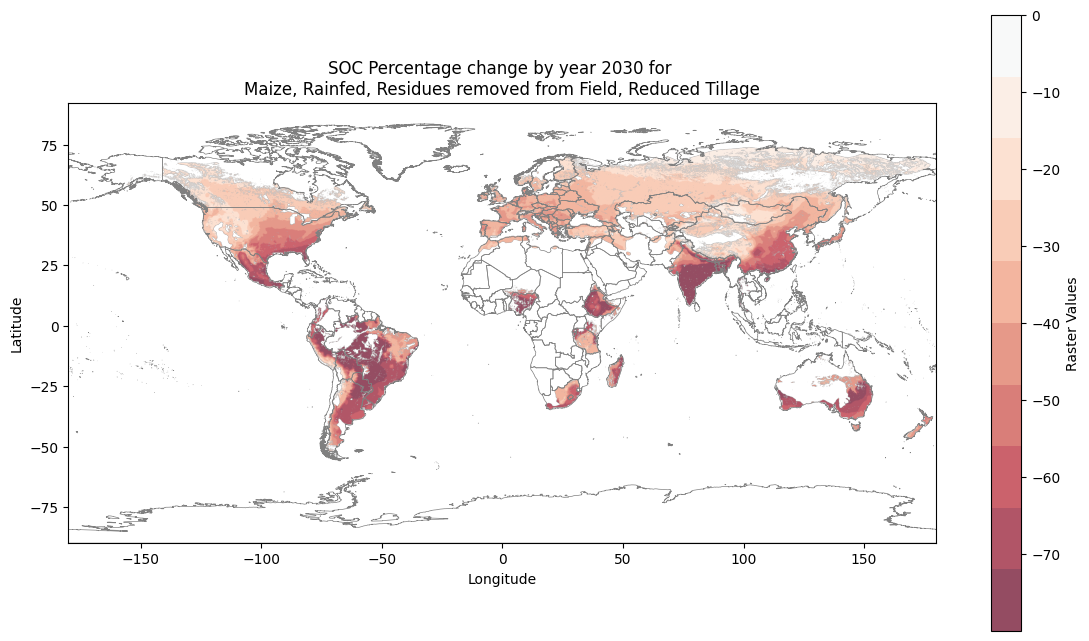

In [64]:
mplot.plot_da_on_world_extremes_cutoff(pct_change_redtill, "SOC Percentage change by year 2030 for \nMaize, Rainfed, Residues removed from Field, Reduced Tillage", band=34, cmap="RdBu", quantiles=10) # type: ignore

As the tendencies is similar to the baseline, the outcoming map is also similar, although with smaller loses. 

Scenarios can also be compared using the function `rothC.calcuate_practice_change_benefit()`, which compares 2 rasters for an specific band. In this case, we can compare between conventional and reduced tillage scenarios.

In [66]:
benefits_ct2rt = rothC.calcuate_practice_change_benefit(raster1_fp=leaf_maize_irr_resoff_ct_2030_tif, raster2_fp=leaf_maize_rf_resoff_rt_2030_tif, band_r1=34, band_r2=34)

Raster has 835,037 different values. Min: 0.84. Max: 221.44
Using quantiles
All positives route


(<Figure size 1400x800 with 2 Axes>,
 <Axes: title={'center': 'SOC Percentage change by year 2030 \nSwitching from conventional to reduced tillage in Maize, Rainfed, Residues removed from Field production'}, xlabel='Longitude', ylabel='Latitude'>)

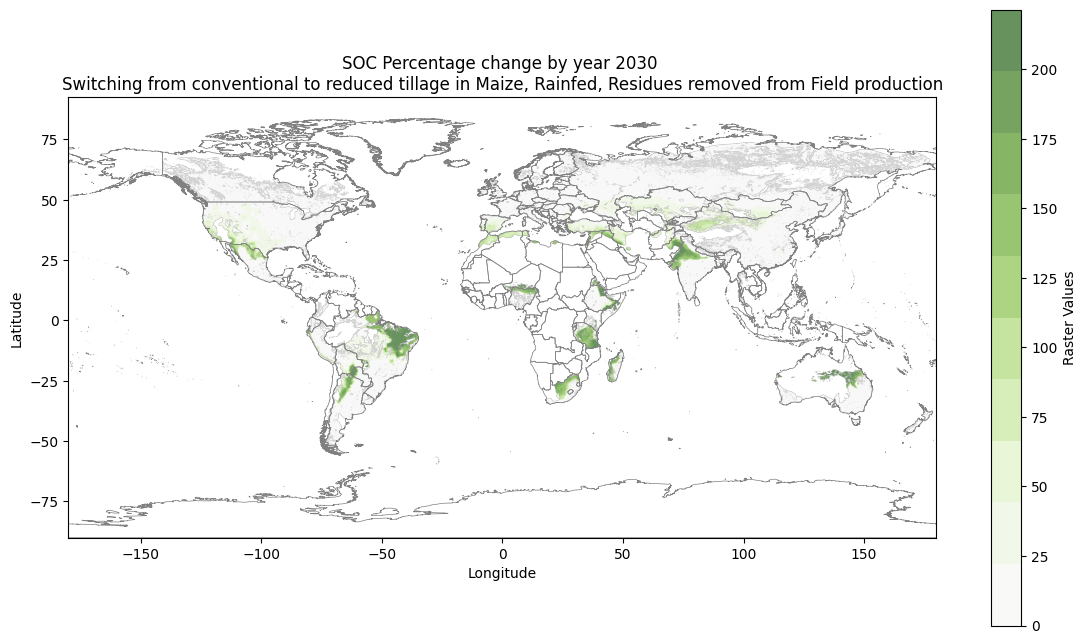

In [69]:
mplot.plot_da_on_world_extremes_cutoff(benefits_ct2rt, "SOC Percentage change by year 2030 \nSwitching from conventional to reduced tillage in Maize, Rainfed, Residues removed from Field production", band=34, cmap="PiYG", quantiles=10) # type: ignore

Where it can be seen that there are small to large benefits depending on soil properties around the world.